On this notebook , we will attempt a preprocessing step before using the RoBERTa model since it has a max input length of 512 and our reviews are much longer. The longest sequence we have is around 1500 so we will break each review into 3 parts which we will be able to trace back to the original review using IDs and then aggregate.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr  7 13:18:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   55C    P8             13W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install datasets
from IPython.display import clear_output
clear_output()

In [4]:
import pandas as pd
from datasets import Dataset, DatasetDict
import torch
import os
import torch
import numpy as np
from google.colab import drive
from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification, RobertaTokenizerFast, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
import torch

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected, using CPU.")


Using GPU: NVIDIA L4


In [6]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [7]:
# Loading the dataset from drive
df = pd.read_csv("/content/drive/My Drive/DSC 514 NLP/sampled_data.csv")
df.head()

,movie_id,plot_summary,duration,genre,rating_x,release_date,plot_synopsis,review_date,user_id,is_spoiler,review_text,rating_y,review_summary,whole_review
0,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,1 February 2006,ur5945598,True,Oh where can I start on why alleged comedians ...,10,Chaplin strikes comic gold!,Oh where can I start on why alleged comedians ...
1,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,11 August 2005,ur5805910,True,"We follow ""the little fellow"" (Chaplin), in hi...",10,Chaplin's delightful bonhomie & innocence,"We follow ""the little fellow"" (Chaplin), in hi..."
2,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,22 June 2000,ur0773000,False,I recently saw this movie with a live orchestr...,9,"As fresh, funny, and moving as the day it was ...",I recently saw this movie with a live orchestr...
3,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,9 March 2009,ur0361658,False,The Gold Rush (1925) was a big undertaking for...,10,The Cinema of Charles Chaplin: The Gold Rush,The Gold Rush (1925) was a big undertaking for...
4,tt0017136,"Sometime in the future, the city of Metropolis...",2h 33min,"['Drama', 'Sci-Fi']",8.3,1927-03-13,"The film is set in the year 2026, in the extra...",7 March 2015,ur13977076,True,This sci-fi classic is set in a future where t...,10,A science fiction classic,This sci-fi classic is set in a future where t...


We will assign a unique ID to each review (review_id) before splitting the review:

In [35]:
# Unique review ID to each row
df['review_id'] = df.index

In [36]:
# Creating a HuggingFace dataset
dataset = Dataset.from_pandas(df[['review_text', 'is_spoiler', 'review_id']])

In [37]:
# Loading the tokenizer for roberta from pretrained
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

```python
# Next, this function will split the review into parts of 512 tokens each which is the maximum input for roberta
# and will also keep the review_id and the label for each chunk created        

def chunk_review(batch):
    chunk_size = 512  # Maximum tokens allowed by RoBERTa
    stride = 256  # Overlapping size for better context retention
    all_chunks = []  # A list to store all results

    # Looping through each row in the batch
    for review_text, is_spoiler, review_id in zip(batch["review_text"], batch["is_spoiler"], batch["review_id"]):
        # Tokenizing with truncation and returning overflow tokens if necessary
        tokens = tokenizer(review_text,
                           return_overflowing_tokens=True,
                           truncation=True,
                           max_length=chunk_size,
                           stride=stride)

        input_ids_list = tokens["input_ids"]
        attention_mask_list = tokens["attention_mask"]
        
        # Now, we split the review to chunks of size 512 max
        for input_ids, attention_mask in zip(input_ids_list, attention_mask_list):
            all_chunks.append({
                "review_id": review_id,
                "input_ids": input_ids,  # getting the id for the tokens, ensuring this is a list of integers (token IDs)
                "attention_mask": attention_mask, # getting the attention mask
                "label": is_spoiler
            })

    # Returning a dictionary of lists to fit the format of HuggingFace
    return {
        "review_id": [chunk["review_id"] for chunk in all_chunks],
        "input_ids": [chunk["input_ids"] for chunk in all_chunks],  # Should be a list of lists
        "attention_mask": [chunk["attention_mask"] for chunk in all_chunks],
        "label": [chunk["label"] for chunk in all_chunks]
    }

# So now we can apply the chunking
# changed batched to True since now we are returning a list
dataset_chunked = dataset.map(chunk_review, batched=True, batch_size=1, remove_columns=["review_text", "is_spoiler"])
dataset_chunked = dataset_chunked.flatten_indices()
```

In [38]:
from datasets import Dataset, Features, Sequence, Value

def process_and_chunk(dataset):
    chunk_size = 512
    stride = 256
    all_chunks = {"review_id": [], "input_ids": [], "attention_mask": [], "label": []}

    for example in dataset:
        review_text = example["review_text"]
        is_spoiler = example["is_spoiler"]
        review_id = example["review_id"]

        # Tokenizing the text with proper settings
        tokens = tokenizer(
            review_text,
            padding=False,
            truncation=True,
            max_length=chunk_size,
            stride=stride,
            return_overflowing_tokens=True,
            return_tensors=None
        )

        input_ids_list = tokens.get("input_ids", [])
        attention_mask_list = tokens.get("attention_mask", [])

        # If the tokenizer returns a single chunk instead of multiple
        if isinstance(input_ids_list[0], int):
            # Wrap it in a list to maintain uniformity
            input_ids_list = [input_ids_list]
            attention_mask_list = [attention_mask_list]

        # Process each chunk
        for input_ids, attention_mask in zip(input_ids_list, attention_mask_list):
            all_chunks["review_id"].append(review_id)
            all_chunks["input_ids"].append(input_ids)  # Store as a list of integers
            all_chunks["attention_mask"].append(attention_mask)  # Store as a list of integers
            all_chunks["label"].append(int(is_spoiler))

    return all_chunks


In [39]:
# Process the dataset manually

features = Features({
    'review_id': Value('int64'),
    'input_ids': Sequence(Value('int32')),  # Forces input_ids to be stored as lists of integers
    'attention_mask': Sequence(Value('int8')),  # Forces attention_mask to be stored as lists of integers
    'label': Value('int64')
})


# Convert the dataset to a list of dictionaries for processing
dataset_list = [dataset[i] for i in range(len(dataset))]

# Process the dataset manually
processed_chunks = process_and_chunk(dataset_list)

# Create the dataset using the specified schema
dataset_chunked = Dataset.from_dict(processed_chunks, features=features)


In [40]:
print(dataset_chunked.features)
print(type(dataset_chunked['input_ids'][0]))  # Should be <class 'list'>
print(type(dataset_chunked['input_ids'][0][0]))  # Should be <class 'int'>


{'review_id': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'label': Value(dtype='int64', id=None)}
<class 'list'>
<class 'int'>


In [41]:
print(dataset_chunked[0]) # this should not return nested lists

{'review_id': 0, 'input_ids': [0, 7516, 147, 64, 38, 386, 15, 596, 1697, 28972, 197, 1183, 42, 822, 13, 7125, 116, 30800, 6, 24, 18, 95, 6269, 4, 45527, 6, 18606, 28291, 18, 2664, 3914, 2048, 16, 10, 4613, 410, 22650, 6, 61, 2386, 123, 7, 109, 5, 144, 10861, 17605, 19650, 821, 8299, 4, 497, 5, 276, 86, 6, 37, 18, 10, 8840, 2598, 6, 3030, 7, 146, 402, 9, 1003, 4, 9136, 6, 37, 7416, 9, 33884, 8, 5, 372, 1151, 77, 37, 5315, 1637, 6, 53, 15, 39, 9794, 7, 465, 5, 1637, 4691, 293, 6, 37, 6952, 13, 215, 3280, 383, 25, 20310, 6, 689, 36, 3983, 7022, 39, 9759, 8, 4441, 24, 13, 3630, 16, 10, 4187, 1310, 43, 8, 657, 36, 700, 14528, 5712, 13, 390, 54, 32, 95, 7209, 198, 123, 7, 146, 1531, 9, 123, 6, 8, 47, 64, 75, 244, 619, 13, 5, 2173, 43, 178, 6, 9, 768, 6, 358, 1310, 6, 358, 30146, 16, 888, 233, 9, 5, 527, 6, 98, 24, 18, 45, 95, 10, 651, 9, 7031, 1545, 12, 31586, 11248, 4, 85, 18, 67, 966, 19280, 14, 37, 18, 215, 10, 9256, 12576, 6, 37, 18, 2882, 7, 458, 5, 2441, 19, 39, 1029, 12, 16823, 8, 64,

In [42]:
print(type(dataset_chunked))
print(dataset_chunked.features)

<class 'datasets.arrow_dataset.Dataset'>
{'review_id': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'label': Value(dtype='int64', id=None)}


In [43]:
# Splitting after apllying the chunking using the train-test split from Dataset , we want to keep the review_id
# First, split the dataset into train and test (e.g., 80% train, 20% test)

train_val_dataset = dataset_chunked.train_test_split(test_size=0.2, seed=42)

train_val_split = train_val_dataset['train'].train_test_split(test_size=0.1, seed=42)

dataset_split = DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': train_val_dataset['test']
})

In [44]:
# Formatting for Pytorch in order to convert these columns and be ready to used from Hugging Face
dataset_split.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [45]:
# Accessing the 'input_ids' column directly
token_lengths = [len(input_ids) if isinstance(input_ids, list) else None for input_ids in dataset_chunked['input_ids']]

# Remove None values from token_lengths
token_lengths = [length for length in token_lengths if length is not None]

# Print the information
print(f"Total chunks: {len(token_lengths)}")
print(f"Max token length in our chunks: {max(token_lengths)}")
print(f"Chunks > 512: {sum(l > 512 for l in token_lengths)}")


Total chunks: 5335
Max token length in our chunks: 512
Chunks > 512: 0


In [46]:
# Counting the token legths
# Access the 'input_ids' column directly
token_lengths = [len(input_ids) for input_ids in dataset_chunked['input_ids']]

# Print the information
print(f"Total chunks: {len(token_lengths)}")
print(f"Max token length in our chunks: {max(token_lengths)}")
print(f"Chunks > 512: {sum(l > 512 for l in token_lengths)}")



Total chunks: 5335
Max token length in our chunks: 512
Chunks > 512: 0


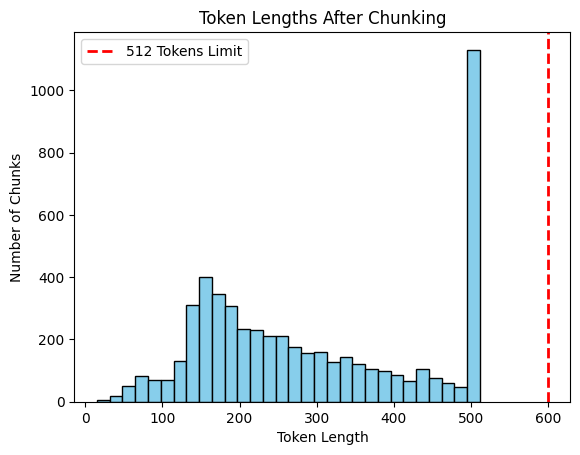

In [47]:
# From the cell above we have verified that the splitting was performed correctly

# Checking also with plot that indeed the tokens have length less than the maximum that roberta can take
plt.hist(token_lengths, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=600, color='red', linestyle='--', linewidth=2, label='512 Tokens Limit')
plt.title('Token Lengths After Chunking')
plt.xlabel('Token Length')
plt.ylabel('Number of Chunks')
plt.legend()
plt.show()

From the plot above we can see that everything is working as we wanted, there are no chunks with length larger than 512. We can see a lot of smaller chunks and a spike at 512 where the longer reviews were splitted. Now we can load the roberta model.

In [48]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

label2id = { "non-spoiler": 0,"spoiler": 1}
id2label = {0: "non-spoiler",1: "spoiler"}

model_name = "roberta-base"

config = RobertaConfig.from_pretrained(
    model_name,
    output_hidden_states = False,
    num_labels = 2,
    label2id = label2id,
    id2label = id2label )

In [49]:
# Initializing the model
model = RobertaForSequenceClassification.from_pretrained(model_name, config=config)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
# Batch size and gradient accumulation -> these can be changed if needed
batch_size = 16
gradient_accumulation_steps = 2

In [51]:
# Logging steps
logging_steps = len(dataset_split["train"]) // (batch_size * gradient_accumulation_steps)

In [52]:
# Directory to save output
OUTPUT_DIR = "./"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [53]:
# Training arguments for roberta
# we want to match the chunked dataset so we will modify the previous arguements

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "roberta-model"),
    evaluation_strategy="epoch",                            # evaluate after every epoch
    save_strategy="epoch",                                  # and save
    logging_strategy="steps",
    logging_steps=logging_steps,                            # we calculated this above
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    num_train_epochs=3,                                   # number of epochs to train
    learning_rate=2e-5,                                   # learning rate
    weight_decay=0.02,                                    # weight decay
    load_best_model_at_end=True,                          # we want to get the best model by validation loss
    metric_for_best_model="eval_loss",                    # metric to use will be eval_loss
    greater_is_better=False,                              # we want to minimize the loss
    save_total_limit=2,
    logging_dir="./logs",
    fp16=True,                                             # Enable mixed-precision training to save memory
    report_to="wandb" )                                   # to use the Weights & Biases site

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [54]:
# Trainer setup
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["validation"],  # Use validation set for evaluation during training
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


<ipython-input-54-5f33fad406cb>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [55]:
# Finally, time to train
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.646000,0.595947
2,0.503700,0.598259


TrainOutput(global_step=360, training_loss=0.5743415090772841, metrics={'train_runtime': 186.0667, 'train_samples_per_second': 61.929, 'train_steps_per_second': 1.935, 'total_flos': 3005248307656560.0, 'train_loss': 0.5743415090772841, 'epoch': 2.979253112033195})

In [56]:
# After training to calculate the metrics

# In order to predict on the test data
y_test = dataset_split["test"]
preds_output = trainer.predict(dataset_split["test"])
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = preds_output.label_ids

In [57]:
y_test

array([1, 1, 1, ..., 1, 1, 0])

In [58]:
# Metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

# Evaluating
print(f"F1 Score : {f1_score(y_test, y_preds)}")
print(f"Accuracy : {accuracy_score(y_test, y_preds)}")
print(f"Precision: {precision_score(y_test, y_preds)}")
print(f"Recall   : {recall_score(y_test, y_preds)}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_preds)}")
print(classification_report(y_test, y_preds))

F1 Score : 0.7171806167400882
Accuracy : 0.6991565135895033
Precision: 0.6806020066889632
Recall   : 0.7579143389199255
ROC AUC  : 0.6987684902146797
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       530
           1       0.68      0.76      0.72       537

    accuracy                           0.70      1067
   macro avg       0.70      0.70      0.70      1067
weighted avg       0.70      0.70      0.70      1067



In [59]:
model = trainer.model
model.save_pretrained(os.path.join(OUTPUT_DIR, 'roberta-model/pretrained'), save_config=True)

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3309: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(


We evaluate and make predictions before aggregating.
The function of trainer.predict() is run on the test set which is also splitted into chunks. We will now aggregate by the review id to see how many of the full reviews are considered spoilers.

In [60]:
# Check what columns are present in your test dataset
print(dataset_split["test"].column_names)


['review_id', 'input_ids', 'attention_mask', 'label']


In [61]:
# Extracting all review_ids as a list
review_ids = dataset_split["test"]['review_id']


In [62]:
# Print the keys of a single row
print(dataset_split["test"][0].keys())


dict_keys(['input_ids', 'attention_mask', 'label'])


In [63]:
review_ids

[4384,
 2140,
 3189,
 1543,
 1481,
 5016,
 4854,
 4461,
 956,
 1183,
 863,
 2985,
 5027,
 1433,
 2558,
 4099,
 4929,
 4885,
 4122,
 1962,
 4863,
 265,
 1552,
 5293,
 3969,
 2234,
 2865,
 2862,
 2018,
 3353,
 2437,
 5151,
 4743,
 1888,
 324,
 3202,
 930,
 4691,
 3103,
 3951,
 672,
 5159,
 954,
 1712,
 497,
 3301,
 1158,
 2370,
 1725,
 3934,
 815,
 1235,
 1131,
 3486,
 4938,
 2011,
 820,
 770,
 3050,
 3939,
 2967,
 1063,
 3666,
 5120,
 854,
 1244,
 233,
 2304,
 4480,
 1715,
 3993,
 983,
 1280,
 1528,
 245,
 2195,
 39,
 3812,
 1935,
 2346,
 4602,
 3724,
 517,
 330,
 2308,
 665,
 751,
 3998,
 1843,
 1856,
 4252,
 1821,
 2091,
 5087,
 4532,
 3342,
 1961,
 1921,
 4902,
 4404,
 4546,
 5317,
 2981,
 4328,
 5295,
 1592,
 2953,
 1148,
 2843,
 429,
 127,
 1072,
 2222,
 285,
 2888,
 3051,
 941,
 643,
 871,
 1204,
 3234,
 609,
 896,
 724,
 1324,
 3880,
 5055,
 986,
 1334,
 2690,
 2036,
 2470,
 3463,
 3968,
 293,
 2566,
 2595,
 2519,
 223,
 5262,
 350,
 381,
 656,
 4475,
 2823,
 1389,
 1834,
 530,
 

In [64]:
# Extracting review_ids with indexing
review_ids = dataset_split["test"]["review_id"]
indexed_review_ids = {i: review_id for i, review_id in enumerate(review_ids)}
indexed_review_ids

{0: 4384,
 1: 2140,
 2: 3189,
 3: 1543,
 4: 1481,
 5: 5016,
 6: 4854,
 7: 4461,
 8: 956,
 9: 1183,
 10: 863,
 11: 2985,
 12: 5027,
 13: 1433,
 14: 2558,
 15: 4099,
 16: 4929,
 17: 4885,
 18: 4122,
 19: 1962,
 20: 4863,
 21: 265,
 22: 1552,
 23: 5293,
 24: 3969,
 25: 2234,
 26: 2865,
 27: 2862,
 28: 2018,
 29: 3353,
 30: 2437,
 31: 5151,
 32: 4743,
 33: 1888,
 34: 324,
 35: 3202,
 36: 930,
 37: 4691,
 38: 3103,
 39: 3951,
 40: 672,
 41: 5159,
 42: 954,
 43: 1712,
 44: 497,
 45: 3301,
 46: 1158,
 47: 2370,
 48: 1725,
 49: 3934,
 50: 815,
 51: 1235,
 52: 1131,
 53: 3486,
 54: 4938,
 55: 2011,
 56: 820,
 57: 770,
 58: 3050,
 59: 3939,
 60: 2967,
 61: 1063,
 62: 3666,
 63: 5120,
 64: 854,
 65: 1244,
 66: 233,
 67: 2304,
 68: 4480,
 69: 1715,
 70: 3993,
 71: 983,
 72: 1280,
 73: 1528,
 74: 245,
 75: 2195,
 76: 39,
 77: 3812,
 78: 1935,
 79: 2346,
 80: 4602,
 81: 3724,
 82: 517,
 83: 330,
 84: 2308,
 85: 665,
 86: 751,
 87: 3998,
 88: 1843,
 89: 1856,
 90: 4252,
 91: 1821,
 92: 2091,
 93: 508

In [65]:
# Creating a pandas dataframe to aggregate and store data
# The dataframe contains the review id , the true labels and the predicted ones
df_preds = pd.DataFrame({ "review_id": review_ids, "y_test": y_test, "y_pred": y_preds })

In [66]:
df_preds

,review_id,y_test,y_pred
0,4384,1,0
1,2140,1,0
2,3189,1,1
3,1543,0,1
4,1481,1,1
...,...,...,...
1062,4232,1,1
1063,4184,1,1
1064,2013,1,1
1065,4212,1,1


In [67]:
# Now, we aggregate the predictions by the review
# What we want to do is to consider the whole review as a spoiler even if only one chunk is predicted as a spoiler

agg_preds = df_preds.groupby("review_id").agg({"y_test": "max", "y_pred": "max"}).reset_index()

In [68]:
agg_preds

,review_id,y_test,y_pred
0,8,1,1
1,9,1,1
2,11,0,0
3,13,1,1
4,16,1,1
...,...,...,...
1062,5316,0,1
1063,5317,1,0
1064,5320,0,1
1065,5329,0,0


In [69]:
# Evaluating again, with the same metrics this time the whole reviews

print(f"F1 Score : {f1_score(agg_preds['y_test'], agg_preds['y_pred'])}")
print(f"Accuracy : {accuracy_score(agg_preds['y_test'], agg_preds['y_pred'])}")
print(f"Precision: {precision_score(agg_preds['y_test'], agg_preds['y_pred'])}")
print(f"Recall   : {recall_score(agg_preds['y_test'], agg_preds['y_pred'])}")
print(f"ROC AUC  : {roc_auc_score(agg_preds['y_test'], agg_preds['y_pred'])}")
print(classification_report(agg_preds['y_test'], agg_preds['y_pred']))

F1 Score : 0.7171806167400882
Accuracy : 0.6991565135895033
Precision: 0.6806020066889632
Recall   : 0.7579143389199255
ROC AUC  : 0.6987684902146797
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       530
           1       0.68      0.76      0.72       537

    accuracy                           0.70      1067
   macro avg       0.70      0.70      0.70      1067
weighted avg       0.70      0.70      0.70      1067

